In [1]:
import numpy as np
import matplotlib.pyplot as plt
from traj_opt import TrajOpt
from scipy.optimize import minimize, Bounds, NonlinearConstraint

import matplotlib.animation as animation
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

In [2]:
ndof = 2

## 2 DoF - Reaching task with 1 via point, optimization of the duration

In [3]:
l1 = 1.
l2 = 0.5

def fk_x(q):
    return np.array([l1 * np.cos(q[0]) + l2 * np.cos(q[0]+q[1])])
    
def fk_y(q):
    return l1 * np.sin(q[0]) + l2 * np.sin(q[0]+q[1])

def J_x(q):
    return np.array([[- l1 * np.sin(q[0]) - l2 * np.sin(q[0]+q[1]),- l2 * np.sin(q[0]+q[1])]])
    
def J_y(q):
    return np.array([[l1 * np.cos(q[0]) + l2 * np.cos(q[0]+q[1]),l2 * np.cos(q[0]+q[1])]])

def get_fk_1(x):
    q_1 = x[2:4]
    return fk_x(q_1)

def get_fk_2(x):
    q_2 = x[4:]
    return fk_y(q_2)

In [4]:
def getIK_x(q0, g, alpha=0.1, numIter=100):
    q = q0
    for i in range(numIter):
        q_ = q - (alpha * np.linalg.pinv(J_x(q)) * (fk_x(q) - g)).reshape(2)
        q = q_
    return q_
    
def getIK_y(q0, g, alpha=0.1, numIter=100):
    q = q0
    for i in range(numIter):
        q_ = q - (alpha * np.linalg.pinv(J_y(q)) * (fk_y(q) - g)).reshape(2)
        q = q_
    return q_

In [5]:
def get_dq_max(x):
    N = 2
    ndof = 2
    h = x[:2]
    q_1 = x[2:4]
    q_2 = x[4:]
    to.setup_task(h)
    t_max = np.zeros(N*ndof)
    w = np.concatenate((q_0, q_1, q_2, dq_0, dq_2))
    for n in range(N):
        Omega = to.get_Omega(n)
        for d in range(ndof):
            w_d = w[d::ndof]
            alpha = Omega @ w_d
            t_max[n*ndof+d] = np.clip(np.sum(h[:n]) + alpha[1] / alpha[0], np.sum(h[:n]), np.sum(h[:n+1]))
    
    return to.get_dy(t_max, np.concatenate((q_0, q_1, q_2)), dq_0, dq_2).flatten()

In [6]:
def get_ddq_max(x):
    N = 2
    ndof = 2
    h = x[:2]
    q_1 = x[2:4]
    q_2 = x[4:]
    to.setup_task(h)
    t_nodes = np.zeros(N+1)
    for n in range(N):
        t_nodes[n+1] = np.sum(h[:n+1])
    
    return to.get_ddy(t_nodes, np.concatenate((q_0, q_1, q_2)), dq_0, dq_2).flatten()

In [7]:
x_1 = 1.2
y_2 = 1.2

N_samples = 100

q_samples_1 = np.zeros((N_samples, 2))
q_samples_2 = np.zeros((N_samples, 2))

for n in range(N_samples):
    q_init = np.array([np.random.uniform(0.0,np.pi), np.random.uniform(-np.pi,np.pi)])
    q_samples_1[n] = getIK_x(q_init, x_1)
    q_samples_2[n] = getIK_y(q_init, y_2)

In [8]:
q_0 = np.array([np.random.uniform(0.8,np.pi-0.8), np.random.uniform(-np.pi+0.8,np.pi-0.8)])
dq_0 = np.array([0., 0.])
dq_2 = np.array([0., 0.])

q_1_init = np.array([np.random.uniform(0.8,np.pi-0.8), np.random.uniform(-np.pi+0.8,np.pi-0.8)]) # getIK_x(q_0, x_1)
q_2_init = np.array([np.random.uniform(0.8,np.pi-0.8), np.random.uniform(-np.pi+0.8,np.pi-0.8)]) # getIK_y(q_1_init, y_2)

print(q_0)
print(dq_0)
print(q_1_init)
print(q_2_init)
print(dq_2)

dq_lim = 0.8
ddq_lim = 2

to = TrajOpt(2)
    
fun = lambda x: x[0] + x[1]
bound = Bounds(np.array([1e-3, 1e-3, 0, -np.pi, 0, -np.pi]), np.array([np.inf, np.inf, np.pi, np.pi, np.pi, np.pi]), keep_feasible=True)
nlc_fk_1 = NonlinearConstraint(get_fk_1, x_1-1e-3, x_1+1e-3)
nlc_fk_2 = NonlinearConstraint(get_fk_2, y_2-1e-3, y_2+1e-3)
nlc_dq = NonlinearConstraint(get_dq_max, -dq_lim, dq_lim)
nlc_ddq = NonlinearConstraint(get_ddq_max, -ddq_lim, ddq_lim)

import time
start = time.time()

res = minimize(fun, np.array([.1, .1, q_1_init[0], q_1_init[1], q_2_init[0], q_2_init[1]]), method='SLSQP', bounds=bound, constraints=[nlc_fk_1, nlc_fk_2, nlc_dq, nlc_ddq])

print("Elapsed time: ",time.time()-start," [s]")

print(res.x, get_dq_max(res.x), get_ddq_max(res.x))
T_opt = res.x[:2]
q_1 = res.x[2:4]
q_2 = res.x[4:]

[1.1214966  1.84628085]
[0. 0.]
[ 1.86554042 -0.88380612]
[ 2.05616269 -0.02379957]
[0. 0.]
Elapsed time:  0.6541569232940674  [s]
[1.66119909 1.25713292 0.24157662 0.85563879 0.77747126 0.69369557] [-0.8        -0.76900016 -0.751942   -0.8         0.63404293 -0.07157012
  0.32576162  0.01662048] [-1.93930473 -1.55755322  1.96545049  0.96121086 -2.         -0.17319285]


In [9]:
h = T_opt
T = np.sum(h)
t = np.linspace(0,T,int(1000*T))
N = 2
ndof = 2

q_nodes = np.concatenate(([q_0], [q_1], [q_2]), axis=0)

to.setup_task(h)

q = to.get_y(t, q_nodes, dq_0, dq_2)
dq = to.get_dy(t, q_nodes, dq_0, dq_2)
ddq = to.get_ddy(t, q_nodes, dq_0, dq_2)

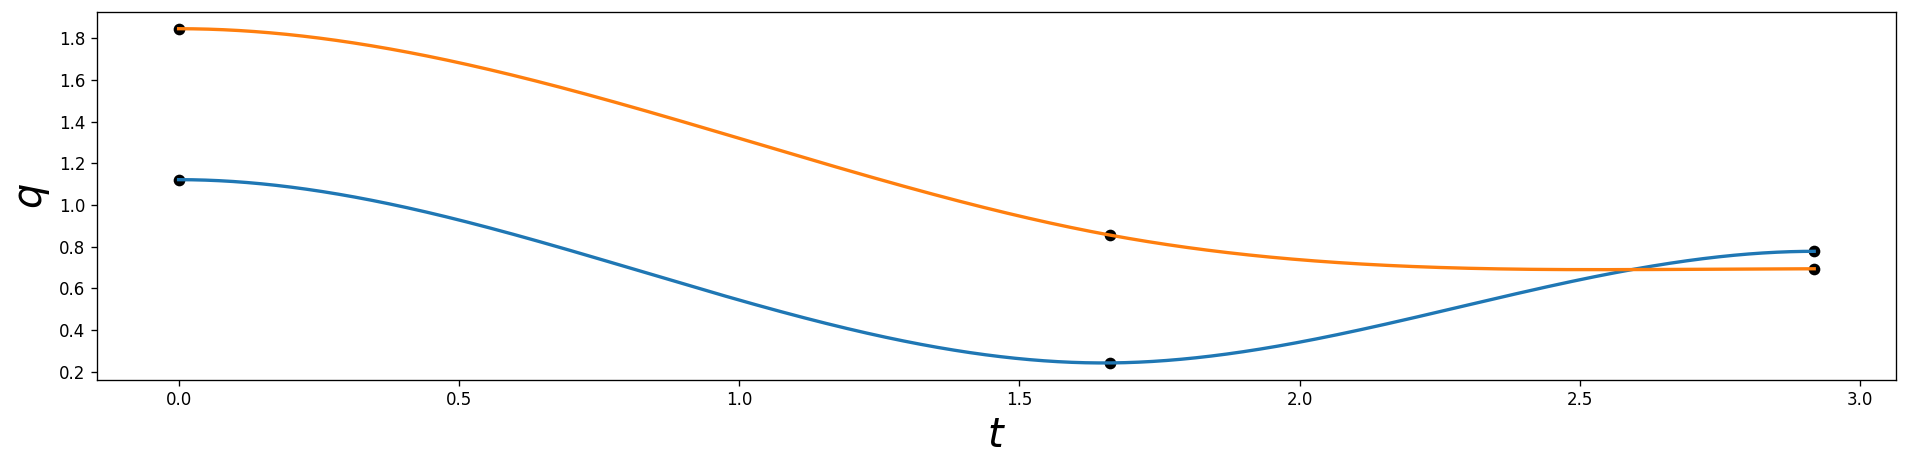

In [10]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$q$', fontsize=fontsize_)

plt.plot(t, q, lw=lw_)

for n in range(N+1):
    plt.scatter(np.sum(h[:n])*np.ones(ndof), q_nodes[n], color='k')
    
plt.tight_layout()
#plt.savefig("space_time_optimal_y.png")

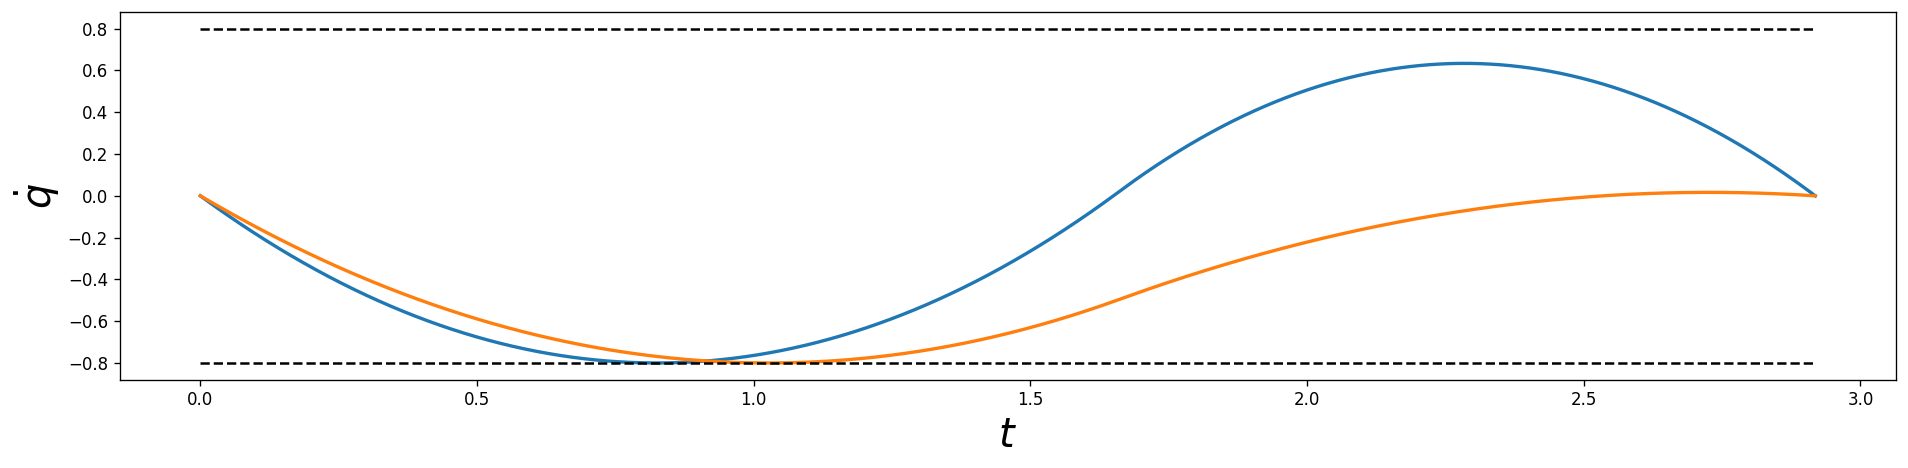

In [11]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\dot{q}$', fontsize=fontsize_)

plt.plot(t, dq, lw=lw_)

plt.plot([0,T], [dq_lim, dq_lim], 'k--')
plt.plot([0,T], [-dq_lim, -dq_lim], 'k--')

plt.tight_layout()
#plt.savefig("space_time_optimal_dq.png")

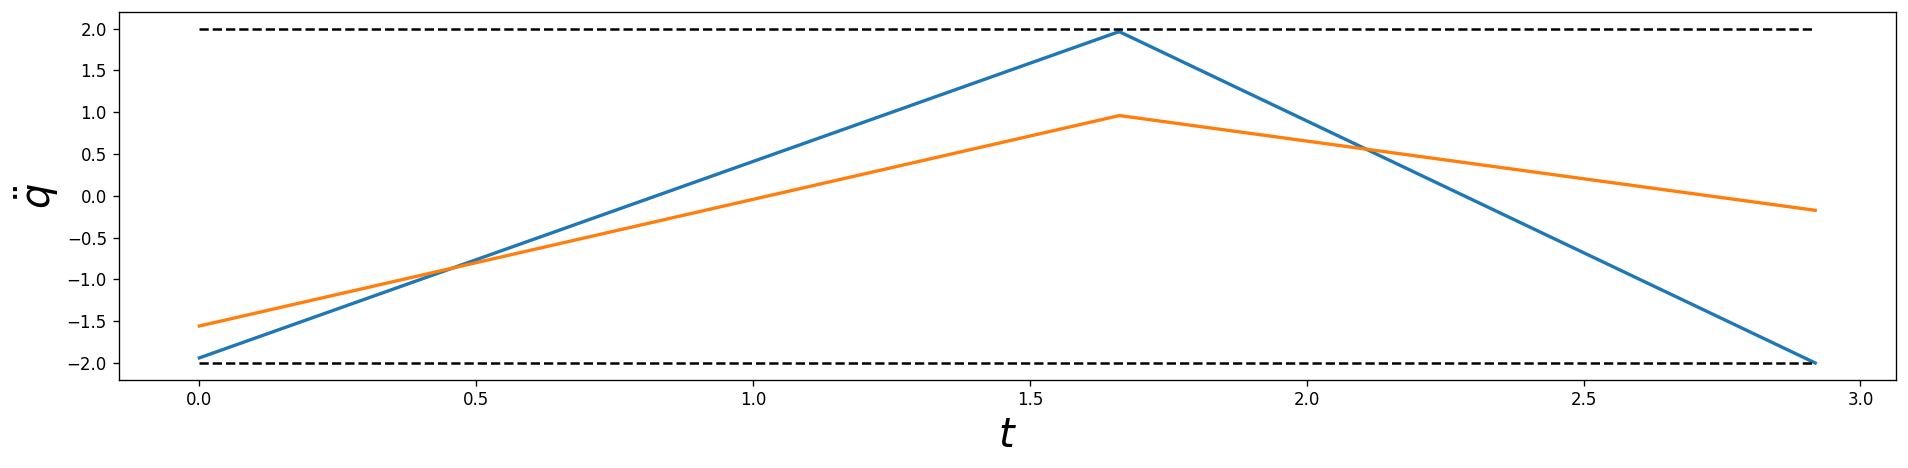

In [12]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\ddot{q}$', fontsize=fontsize_)

plt.plot(t, ddq, lw=lw_)

plt.plot([0,T], [ddq_lim, ddq_lim], 'k--')
plt.plot([0,T], [-ddq_lim, -ddq_lim], 'k--')

plt.tight_layout()
#plt.savefig("space_time_optimal_ddq.png")

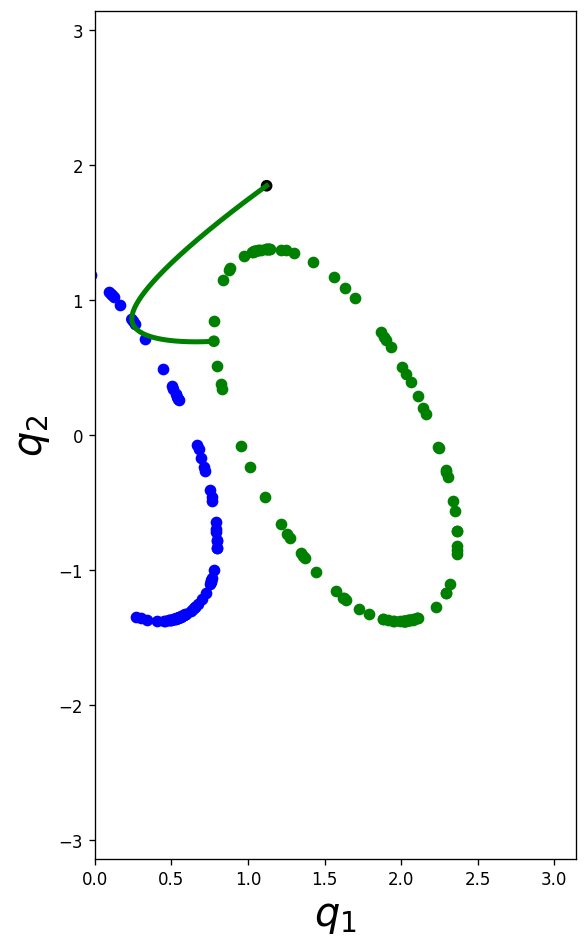

In [13]:
plt.figure(figsize=(5, 8), dpi= 120, facecolor='w', edgecolor='k')

plt.plot(q[:,0], q[:,1], 'g', lw=3)

plt.scatter(q_nodes[:,0], q_nodes[:,1], c=['k','b','g'])

plt.scatter(q_samples_1[:,0], q_samples_1[:,1], color='b')
plt.scatter(q_samples_2[:,0], q_samples_2[:,1], color='g')

plt.xlim(0,np.pi)
plt.ylim(-np.pi,np.pi)

plt.xlabel(r'$q_1$', fontsize = 24)
plt.ylabel(r'$q_2$', fontsize = 24)

plt.tight_layout()
#plt.savefig("space_time_optimal_q.png")

## Visualize the Robot from an array of configurations

In [14]:
Q = q

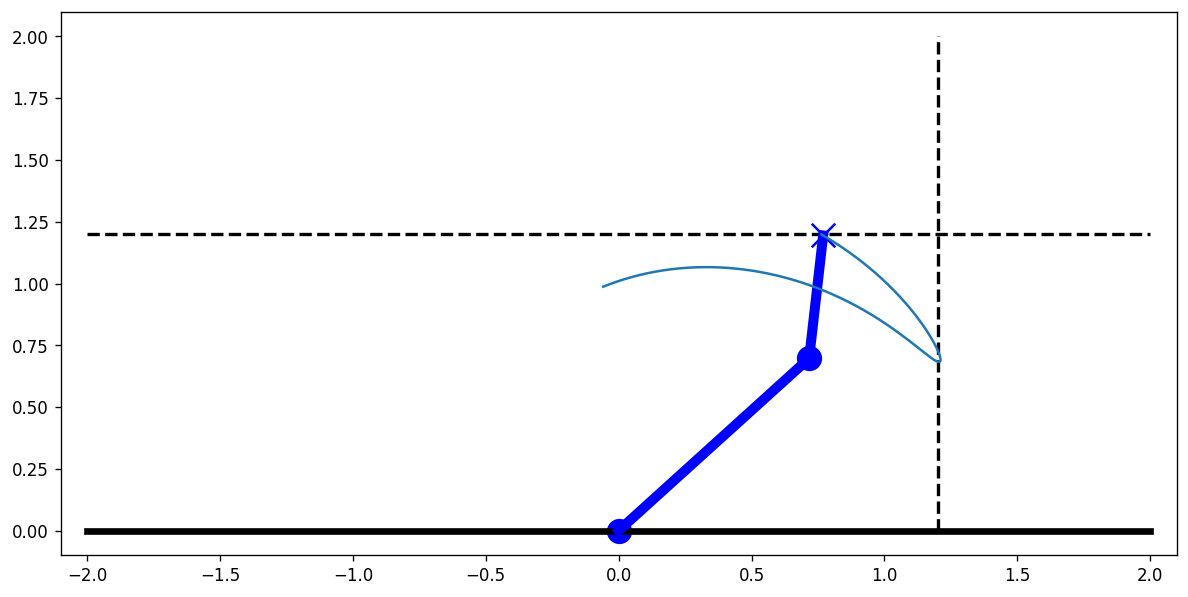

In [15]:
fig, ax = plt.subplots(figsize=(12, 6), dpi= 120, facecolor='w', edgecolor='k')

N_ = len(Q)

dt = T / N_
dt_ani = 0.04

# forward kinematics
Xs = np.zeros((N_,3,2))

for n in range(N_):
    q_ = Q[n]
    Xs[n,1,0] = l1 * np.cos(q_[0])
    Xs[n,1,1] = l1 * np.sin(q_[0])
    Xs[n,2,0] = l1 * np.cos(q_[0]) + l2 * np.cos(q_[0]+q_[1])
    Xs[n,2,1] = l1 * np.sin(q_[0]) + l2 * np.sin(q_[0]+q_[1])
    
# table line
ax.plot([-2., 2.], [0., 0.], lw=4, color='k')

ax.plot([-2., 2.], [y_2, y_2], 'k--', lw=2)
ax.plot([x_1, x_1], [0, 2], 'k--', lw=2)

# draw robot links, joints and end effector
link_plot, = ax.plot(Xs[0,:,0], Xs[0,:,1], lw=6, color='b')
joint_plot = ax.scatter(Xs[0,:-1,0], Xs[0,:-1,1], s=200, color='b')
ee_plot = ax.scatter(Xs[0,-1,0], Xs[0,-1,1], s=200, marker='x', color='b')

ax.plot(Xs[:,-1,0], Xs[:,-1,1])

axes = plt.gca()
axes.set_xlim([-2.1,2.1])
axes.set_ylim([-0.1,2.1])

def animate(i_):
    i = int(i_*dt_ani/dt)
    link_plot.set_xdata(Xs[i,:,0])
    link_plot.set_ydata(Xs[i,:,1])
    joint_plot.set_offsets(Xs[i,:-1,:])
    ee_plot.set_offsets(Xs[i,-1,:])
    return link_plot, joint_plot, ee_plot

ani = animation.FuncAnimation(
    fig, animate, interval=dt_ani*1e3, blit=True, frames=int(T/dt_ani), repeat=False)

HTML(ani.to_html5_video())